In [9]:
from time import sleep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

from settings import TOTALLY_NOT_A_PARSER


from custom_module import parse_yf_esg, get_tickers, parse_mc


# Введение

# Часть первая: Сбор данных

Для сбора данных нам необходимо для начала получить максимально возможное количество тикеров. Самая большая бесплатная база данных, которую мы нашли, это файл на сайте https://www.nasdaq.com/market-activity/stocks/screener
Далее необходимо собрать все необходимые данные: значения оценок esg рисков, прибыль по годам, цены на акции и прочие


In [ ]:
tickers = get_tickers()
df_esg = pd.DataFrame(parse_yf_esg(), index=tickers)
df_true_esg = df_esg[df_esg['Environment Risk Score'].notna()]
df_fins = pd.DataFrame(parse_mc(df_true_esg['Symbol']))

In [7]:
df_true_esg = pd.read_csv('true_esg.csv')
df_fin = pd.read_csv('financials.csv')

In [ ]:
df_fins = pd.DataFrame(parse_mc(df_true_esg['Symbol'])[0])

In [ ]:
df_fins.to_csv('financials.csv')

EDA

In [6]:
df_true_esg

,Symbol,Environment Risk Score,Social Risk Score,Governance Risk Score
0,A,0.3,8.6,0.3
1,AA,14.3,5.9,14.3
2,AAL,11.5,12.3,11.5
3,AAP,0.1,8.3,0.1
4,AAPL,0.6,6.9,0.6
...,...,...,...,...
776,YUM,4.0,12.0,4.0
777,Z,1.0,13.0,1.0
778,ZBH,4.0,15.0,4.0
779,ZTR,9.0,9.0,9.0


In [8]:
df_fin

,Unnamed: 0,Компания,Чистая прибыль 2019,Чистая прибыль 2020,Чистая прибыль 2021,Капитализация 2019,Капитализация 2020,Капитализация 2021
0,0,A,1.070000e+09,7.190000e+08,1.210000e+09,2.540000e+10,3.600000e+10,4.200000e+10
1,1,AA,-1.120000e+09,-1.700000e+08,4.290000e+08,2.650000e+09,4.270000e+09,1.100000e+10
2,2,AAL,1.690000e+09,-8.880000e+09,-1.990000e+09,1.230000e+10,1.010000e+10,1.110000e+10
3,3,AAP,4.870000e+08,NaN,4.930000e+08,9.900000e+09,NaN,1.560000e+10
4,4,AAPL,5.530000e+10,5.740000e+10,9.470000e+10,1.150000e+12,2.000000e+12,2.740000e+12
...,...,...,...,...,...,...,...,...
776,776,YUM,1.290000e+09,9.040000e+08,1.580000e+09,3.260000e+10,3.070000e+10,3.620000e+10
777,777,Z,-3.050000e+08,-1.620000e+08,-5.280000e+08,9.770000e+09,2.920000e+10,1.260000e+10
778,778,ZBH,1.130000e+09,-1.390000e+08,4.020000e+08,3.100000e+10,3.070000e+10,2.570000e+10
779,779,ZTR,NaN,NaN,NaN,NaN,NaN,NaN


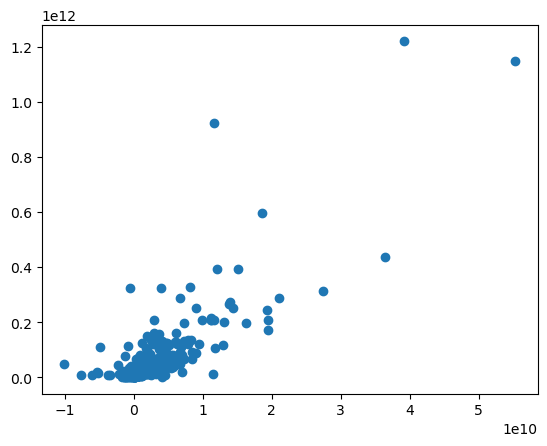

In [10]:
plt.scatter(df_fin['Чистая прибыль 2019'], df_fin['Капитализация 2019'])

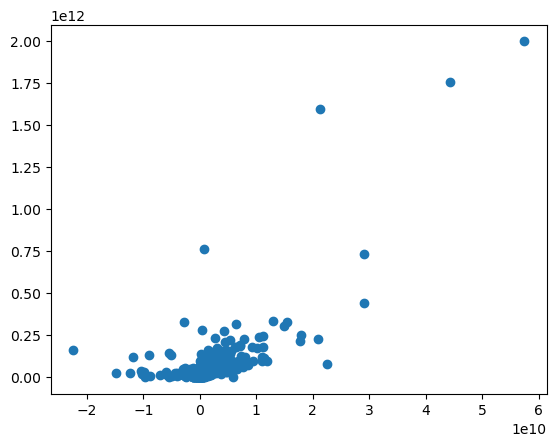

In [11]:
plt.scatter(df_fin['Чистая прибыль 2020'], df_fin['Капитализация 2020'])

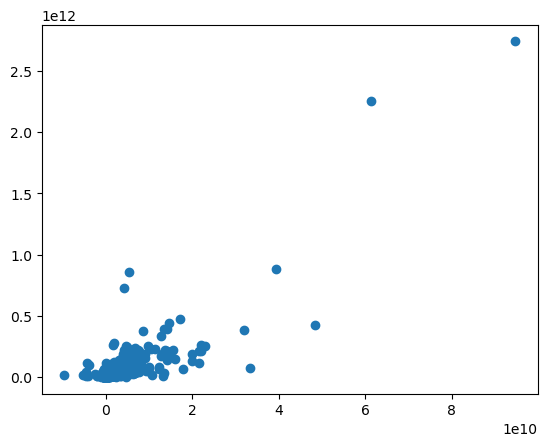

In [12]:
plt.scatter(df_fin['Чистая прибыль 2021'], df_fin['Капитализация 2021'])

In [13]:
df = df_true_esg
df['fall'] = (df_fin['Чистая прибыль 2019']-df_fin['Чистая прибыль 2020'])/df_fin['Чистая прибыль 2019']

In [14]:
df

,Symbol,Environment Risk Score,Social Risk Score,Governance Risk Score,fall
0,A,0.3,8.6,0.3,0.328037
1,AA,14.3,5.9,14.3,0.848214
2,AAL,11.5,12.3,11.5,6.254438
3,AAP,0.1,8.3,0.1,NaN
4,AAPL,0.6,6.9,0.6,-0.037975
...,...,...,...,...,...
776,YUM,4.0,12.0,4.0,0.299225
777,Z,1.0,13.0,1.0,0.468852
778,ZBH,4.0,15.0,4.0,1.123009
779,ZTR,9.0,9.0,9.0,NaN


In [15]:
df['sum'] = df['Environment Risk Score'] + df['Social Risk Score'] + df['Governance Risk Score']

In [31]:
df[df['fall']<0.5]['fall'].corr(df[df['fall']<0.5]['Social Risk Score'])

0.049832557946397134

In [ ]:
df[df['fall']<0.5]['fall'].corr(df[df['fall']<0.5]['Governance Risk Score'])

In [ ]:
df[df['fall']<0.5]['fall'].corr(df[df['fall']<0.5]['Environment Risk Score'])